In [1]:
import ast
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymoo.indicators.hv import Hypervolume
from tqdm import tqdm

from data import constants
from data.eluc_data import ELUCData
from data.eluc_encoder import ELUCEncoder
import experiments.utils as utils
from prsdk.persistence.serializers.neural_network_serializer import NeuralNetSerializer
from prsdk.persistence.serializers.sklearn_serializer import SKLearnSerializer
from prsdk.predictors.predictor import Predictor
from prescriptors.nsga2.land_use_prescriptor import LandUsePrescriptor
from prescriptors.prescriptor_manager import PrescriptorManager
from prescriptors.heuristics.heuristics import PerfectHeuristic
from predictors.percent_change.percent_change_predictor import PercentChangePredictor

In [2]:
FULL_DIR = Path("prescriptors/nsga2/training_runs/eds-rhea")
SEEDED_DIR = Path("prescriptors/nsga2/training_runs/eds")
BASE_DIR = Path("prescriptors/nsga2/training_runs/eds-no-rhea")
FIGURE_DIR = Path("experiments/figures/eds-revisions")
OUTCOMES = ["ELUC", "change"]

In [3]:
def get_ancestry(cand_id: str, df: pd.DataFrame, ancestry: dict):
    if cand_id.startswith("1_"):
        ancestry[cand_id] = {cand_id: 1}
    elif cand_id not in ancestry:
        row = df[df["id"] == cand_id].iloc[0]
        parents = ast.literal_eval(row["parents"])

        # Get ancestries of parents
        parent0_ancestry = get_ancestry(parents[0], df, ancestry)
        parent1_ancestry = get_ancestry(parents[1], df, ancestry)

        # Combine ancestries of parents for this candidate
        combined_ancestry = {k: v for k, v in parent0_ancestry.items()}
        for k, v in parent1_ancestry.items():
            combined_ancestry[k] = combined_ancestry.get(k, 0) + v
        
        ancestry[cand_id] = combined_ancestry

    return ancestry[cand_id]


def construct_pareto_ancestry(results_dir: Path, final_gen: int, outcomes: list[str]):
    all_dfs = [pd.read_csv(results_dir / f"{gen}.csv") for gen in range(1, 101)]
    rhea_df = pd.concat(all_dfs, ignore_index=True).drop_duplicates()
    pareto_df = utils.pareto.get_overall_pareto_df(final_gen, results_dir, outcomes)
    ancestry = {}
    for idx, cand_row in tqdm(pareto_df.iterrows()):
        get_ancestry(cand_row["id"], rhea_df, ancestry)

    return ancestry


def rename_key(k):
    num = int(k.split("_")[1])
    if num == 0:
        return "100%"
    elif num == 1:
        return "0%"
    else:
        return k


def view_breadth(ax: plt.Axes, results_dir: Path, final_gen: int, outcomes: list[str], verbose=False, title: str=None):
    ancestry = construct_pareto_ancestry(results_dir, final_gen, outcomes)

    counts = {}
    for a in ancestry.values():
        for parent in a:
            counts[parent] = counts.get(parent, 0) + 1

    counts = {rename_key(k): v / len(ancestry) for k, v in counts.items()}
    sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
    if verbose:
        print(sorted_counts)
    ax.bar(sorted_counts.keys(), sorted_counts.values(), color="C0")
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_xlabel("Candidate ID")
    ax.set_ylabel("Proportion of Pareto Front Descended From Candidate")
    title = title if title else "c) Original Ancestry of Original Seeded Pareto Front"
    ax.set_title(title)
    return ax


def view_dna(ax: plt.Axes, results_dir: Path, final_gen: int, outcomes: list[str], verbose=False, title: str=None):
    ancestry = construct_pareto_ancestry(results_dir, final_gen, outcomes)

    total_proportions = {}
    for a in ancestry.values():
        proportions = {parent: count / sum(a.values()) for parent, count in a.items()}
        for parent, proportion in proportions.items():
            total_proportions[parent] = total_proportions.get(parent, 0) + proportion

    total_proportions = {parent: total_proportion / len(ancestry) for parent, total_proportion in total_proportions.items()}
    total_proportions = {rename_key(parent): proportion for parent, proportion in total_proportions.items()}
    assert(np.isclose(sum(list(total_proportions.values())), 1))
    sorted_proportions = dict(sorted(total_proportions.items(), key=lambda item: item[1], reverse=True))
    if verbose:
        print(sorted_proportions)
    ax.bar(sorted_proportions.keys(), sorted_proportions.values(), color="C0")
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_xlabel("Candidate ID")
    ax.set_ylabel("Average Contribution of Candidate")
    title = title if title else "d) Average Contribution of Original Seeded Pareto Front"
    ax.set_title(title)
    return ax

228it [00:00, 1216.83it/s]


{'0%': 0.9377593360995851, '1_30': 0.9087136929460581, '1_75': 0.8907330567081605, '1_56': 0.8741355463347165, '100%': 0.8699861687413555, '1_49': 0.8699861687413555, '1_78': 0.8658367911479945, '1_47': 0.8644536652835408, '1_95': 0.8437067773167358, '1_55': 0.8409405255878285, '1_35': 0.8229598893499308, '1_39': 0.8188105117565698, '1_72': 0.8188105117565698, '1_5': 0.8160442600276625, '1_92': 0.8146611341632088, '1_66': 0.7994467496542186, '1_58': 0.7994467496542186, '1_14': 0.7897648686030428, '1_85': 0.7786998616874136, '1_84': 0.7565698478561549, '1_27': 0.7565698478561549, '1_40': 0.7261410788381742, '1_43': 0.648686030428769, '1_76': 0.607192254495159}


228it [00:00, 1138.88it/s]


{'0%': 0.3064449778105, '1_30': 0.09939220701812632, '1_75': 0.07888308798931044, '1_47': 0.059712108215531176, '1_78': 0.0551445599317042, '1_49': 0.053349117742608004, '1_56': 0.052739731054784286, '100%': 0.04773727966659482, '1_55': 0.037435440482855915, '1_95': 0.037356904811091905, '1_35': 0.018813005030273548, '1_39': 0.017906525712156226, '1_72': 0.017906525712156226, '1_5': 0.01757995432749355, '1_92': 0.016696290580759263, '1_84': 0.01280954626084575, '1_27': 0.01280954626084575, '1_85': 0.011553795408435227, '1_66': 0.011058050784878424, '1_58': 0.011058050784878424, '1_14': 0.010350300476991136, '1_40': 0.004900304323101423, '1_76': 0.00442621227879508, '1_43': 0.003936477335283288}


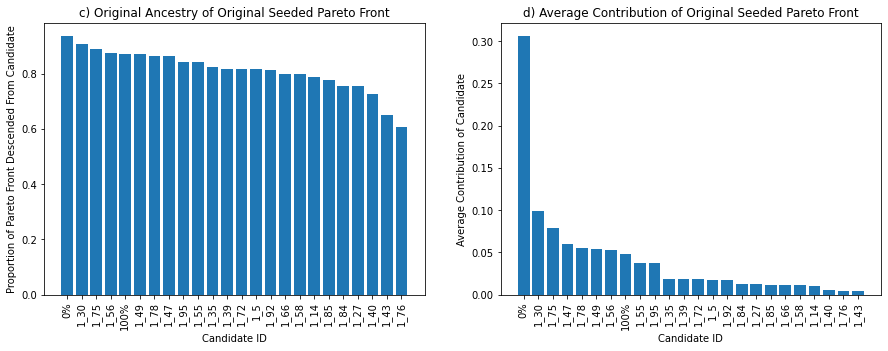

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0] = view_breadth(axes[0], SEEDED_DIR, 100, OUTCOMES, verbose=True)
axes[1] = view_dna(axes[1], SEEDED_DIR, 100, OUTCOMES, verbose=True)
plt.show()

In [5]:
dataset = ELUCData.from_hf()
encoder = dataset.encoder

test_df = dataset.test_df.sample(frac=0.01, random_state=100)
encoded_test_df = encoder.encode_as_df(test_df)

context_df = test_df[constants.CAO_MAPPING["context"]]
encoded_context_df = encoded_test_df[constants.CAO_MAPPING["context"]]

Using the latest cached version of the dataset since projectresilience/ELUC-committed couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/964840/.cache/huggingface/datasets/projectresilience___ELUC-committed/default/0.0.0/c3a972ec8ecc4e87d8551044791c8172dd48e539 (last modified on Tue Apr 30 14:29:47 2024).


In [6]:
nn_serializer = NeuralNetSerializer()
nnp = nn_serializer.load(Path("predictors/trained_models/danyoung--eluc-global-nn"))
change_predictor = PercentChangePredictor()
predictors = {"ELUC": nnp, "change": change_predictor}


In [7]:
pcts = [i / 100 for i in range(0, 101)]

linreg_serializer = SKLearnSerializer()
linreg = linreg_serializer.load(Path("predictors/trained_models/danyoung--eluc-global-linreg"))
coefs = linreg.model.coef_
coef_dict = dict(zip(constants.LAND_USE_COLS, coefs))
reco_coefs = []
for col in constants.RECO_COLS:
    reco_coefs.append(coef_dict[col])

perfect_manager = PrescriptorManager({str(pct): PerfectHeuristic(pct, reco_coefs) for pct in pcts}, predictors)

In [8]:
perfect_results = utils.heuristics.evaluate_prescriptors(perfect_manager, [str(pct) for pct in pcts], context_df, OUTCOMES)

100%|██████████| 101/101 [00:26<00:00,  3.77it/s]


In [9]:
full_results = utils.heuristics.evaluate_experiment(FULL_DIR, 100, context_df, encoder, OUTCOMES, predictors)
seeded_results = utils.heuristics.evaluate_experiment(SEEDED_DIR, 100, context_df, encoder, OUTCOMES, predictors)
base_results = utils.heuristics.evaluate_experiment(BASE_DIR, 100, context_df, encoder, OUTCOMES, predictors)

100%|██████████| 250/250 [01:41<00:00,  2.47it/s]


In [10]:
def compare_paretos(ax: plt.Axes, results_dfs: list[pd.DataFrame], plot_params: list[dict], title: str=None):
    for results_df, params in zip(results_dfs, plot_params):
        results_df = results_df.sort_values(by="change")
        ax.scatter(results_df["change"], results_df["ELUC"], **params)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    ax.set_xlabel("Change")
    ax.set_ylabel("ELUC (tC/ha)")
    title = title if title else "a) Combined Pareto Fronts of Different Levels of RHEA Seeding"
    ax.set_title(title)
    return ax

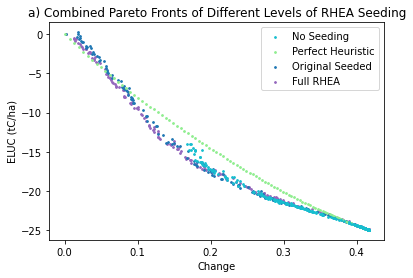

In [11]:
pareto_params = [
    {"label": "Full RHEA", "s": 3, "color": "C4"},
    {"label": "Original Seeded", "s": 3, "color": "C0"},
    {"label": "Perfect Heuristic", "s": 3, "color": "lightgreen"},
    {"label": "No Seeding", "s": 3, "color": "C9"}
]
fig, ax = plt.subplots()
ax = compare_paretos(ax, [full_results, seeded_results, perfect_results, base_results], pareto_params)
plt.show()

In [12]:
def get_hypervolume(results_df: pd.DataFrame, ref_point: np.ndarray, ideal: np.ndarray, outcomes: list[str]):
    metric = Hypervolume(ref_point=ref_point,
                         norm_ref_point=True,
                         zero_to_one=True,
                         ideal=ideal,
                         nadir=ref_point)
    F = results_df[outcomes].values
    return metric.do(F)


def test_hypervolume_all_gens(results_dirs: list[Path], total_gens: int, ref_point: np.ndarray, ideal: np.ndarray, context_df: pd.DataFrame, encoder: ELUCEncoder, predictors: list[Predictor]):

    outcomes = ["ELUC", "change"]
    
    all_hypervolumes = []
    for results_dir in results_dirs:
        all_pareto_df = utils.pareto.get_gens_df(results_dir, list(range(1, total_gens + 1)), pareto=True)
        all_pareto_df = all_pareto_df.drop_duplicates(subset=["id"])

        # TODO: This is hard-coded for now
        candidate_params = {"in_size": len(constants.CAO_MAPPING["context"]),
                        "hidden_size": 16,
                        "out_size": len(constants.RECO_COLS)}
        cands = [utils.heuristics.load_candidate(results_dir, cand_id, candidate_params) for cand_id in all_pareto_df["id"].unique()]
        prescs = {cand.cand_id: LandUsePrescriptor(cand, encoder) for cand in cands}
        manager = PrescriptorManager(prescs, predictors)
        # Compute the test set results for all rank 1 candidates in the entire experiment to cache them for later
        results_df = utils.heuristics.evaluate_prescriptors(manager, list(manager.prescriptors.keys()), context_df, outcomes)

        # Find the overall pareto of each generation then retrieve the results for each candidate from the cached results
        hypervolumes = []
        for gen in tqdm(range(1, total_gens+1)):
            pareto_df = utils.pareto.get_overall_pareto_df(gen, results_dir, outcomes)
            pareto_df = pareto_df.drop(columns=outcomes)
            pareto_df = pareto_df.rename(columns={"id": "cand_id"})
            pareto_df = pareto_df.merge(results_df, how="left", on="cand_id")
            hypervolumes.append(get_hypervolume(pareto_df, ref_point, ideal, outcomes))
        all_hypervolumes.append(hypervolumes)

    return all_hypervolumes

def plot_all_hypervolumes(ax: plt.Axes, all_hypervolumes: list[list[float]], plot_params: list[dict]):
    for hypervolumes, params in zip(all_hypervolumes, plot_params):
        ax.plot(range(1, 101), hypervolumes, **params)
    
    ax.set_ylabel("Hypervolume")
    ax.set_xlabel("Generation")
    ax.set_title("b) Hypervolume of Overall Pareto Fronts Over Time")
    ax.legend()

    return ax

In [13]:
perfect_point = [perfect_results["ELUC"].min(), perfect_results["change"].max()]
ref_point = np.array([0, perfect_point[1]])
ideal = np.array([perfect_point[0], 0])
print(perfect_point)

[-24.92859, 0.416844439380585]


In [14]:
# This takes a long time to run
all_hypervolumes = test_hypervolume_all_gens([BASE_DIR, SEEDED_DIR, FULL_DIR], 100, ref_point, ideal, context_df, encoder, predictors)

100%|██████████| 100/100 [02:17<00:00,  1.38s/it]


In [15]:
perfect_hypervolume = get_hypervolume(perfect_results, ref_point, ideal, OUTCOMES)
all_hypervolumes.insert(1, [perfect_hypervolume]*100)

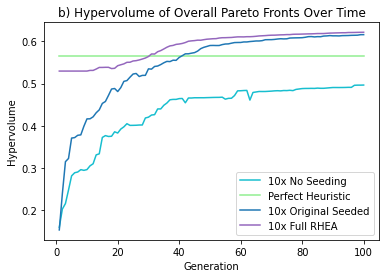

In [16]:
fig, ax = plt.subplots()
hv_params = [
    {"label": "10x No Seeding", "c": "C9"},
    {"label": "Perfect Heuristic", "c": "lightgreen"},
    {"label": "10x Original Seeded", "c": "C0"},
    {"label": "10x Full RHEA", "c": "C4"}
]
ax = plot_all_hypervolumes(ax, all_hypervolumes, hv_params)
plt.show()

In [17]:
def combine_dfs(results_dirs: list[Path], gen: int):
    """
    Gets all Paretos for a generation across all results directories.
    NOTE: We don't filter here because we filter later when we add them to the full Pareto front.
    """
    all_pareto_dfs = []
    for i, results_dir in enumerate(results_dirs):
        df = pd.read_csv(results_dir / f"{gen}.csv")
        df = df[df["NSGA-II_rank"] == 1]
        df["id"] = str(i) + "_" + df["id"]
        all_pareto_dfs.append(df)

    combined_df = pd.concat(all_pareto_dfs, ignore_index=True)
    return combined_df

def get_all_gen_combined_paretos(results_dirs: list[Path], gens: list[int], outcomes: list[str]):
    combined_gen_paretos = []
    for gen in tqdm(gens):
        # Get the combined pareto front for the generation
        combined_df = combine_dfs(results_dirs, gen)

        # If it's the first one just carry on
        if len(combined_gen_paretos) == 0:
            pareto_df = utils.pareto.filter_pareto(combined_df, outcomes)
            combined_gen_paretos.append(pareto_df)
            continue

        # Merge the combined pareto front with the overall pareto front
        last_pareto = combined_gen_paretos[-1]
        merged_df = pd.concat([last_pareto, combined_df], ignore_index=True)
        merged_df = merged_df.drop_duplicates(subset=["id"])

        # Filter the newly merged pareto front
        merged_pareto = utils.pareto.filter_pareto(merged_df, outcomes)

        # Add the merged pareto front to the list
        combined_gen_paretos.append(merged_pareto)
    
    return combined_gen_paretos


from prescriptors.nsga2.candidate import Candidate
import torch

def load_candidate(results_dir: Path, cand_id: str, cand_params: dict[str, int], old=False) -> Candidate:
    gen = int(cand_id.split('_')[0])
    if old:
        gen += 1
    cand_path = results_dir / str(gen) / f"{cand_id}.pt"
    cand = Candidate(**cand_params, device="mps", cand_id=cand_id)
    cand.load_state_dict(torch.load(cand_path, map_location="cpu"))
    return cand


def create_merged_manager(merged_pareto: pd.DataFrame, results_dirs: list[Path], encoder: ELUCEncoder, predictors: list[Predictor]):
    # TODO: This is hard-coded for now
    candidate_params = {"in_size": len(constants.CAO_MAPPING["context"]),
                        "hidden_size": 16,
                        "out_size": len(constants.RECO_COLS)}

    cands = []
    for cand_id in merged_pareto["id"]:
        result_idx, gen, idx = cand_id.split("_")
        results_dir = results_dirs[int(result_idx)]
        cand = load_candidate(results_dir, gen + "_" + idx, candidate_params)
        cand.cand_id = cand_id
        cands.append(cand)

    prescs = {cand.cand_id: LandUsePrescriptor(cand, encoder) for cand in cands}
    merged_manager = PrescriptorManager(prescs, predictors)
    return merged_manager


def set_combined_results(all_gen_paretos: list[pd.DataFrame],
                         results_dirs: list[Path],
                         encoder: ELUCEncoder,
                         predictors: list[Predictor],
                         context_df: pd.DataFrame,
                         outcomes: list[str]) -> pd.DataFrame:
    total_pareto = pd.concat(all_gen_paretos, ignore_index=True)
    total_pareto = total_pareto.drop_duplicates(subset=["id"])

    merged_manager = create_merged_manager(total_pareto, results_dirs, encoder, predictors)
    results_df = utils.heuristics.evaluate_prescriptors(merged_manager, list(merged_manager.prescriptors.keys()), context_df, outcomes)

    pareto_results = []
    for pareto_df in all_gen_paretos:
        pareto_df = pareto_df.rename(columns={"id": "cand_id"})
        pareto_df = pareto_df.drop(columns=outcomes)
        pareto_df = pareto_df.merge(results_df, how="left", on="cand_id")    
        pareto_results.append(pareto_df)

    return pareto_results

def get_combined_hypervolumes(merged_results_dfs: list[list[pd.DataFrame]], ref_point: np.ndarray, ideal: np.ndarray, outcomes: list[str]):
    hypervolumes = []
    for results_df in merged_results_dfs:
        hypervolumes.append(get_hypervolume(results_df, ref_point, ideal, outcomes))
    return hypervolumes

In [18]:
# This takes about 1.5 hours to run
a = 101
noseed_dir = "/Users/964840/workspace/transfer/training_runs/noseed"
noseed_dirs = [Path(noseed_dir + f"/eds-no-rhea_{i}") for i in range(10)]
merged_noseed = get_all_gen_combined_paretos(noseed_dirs, list(range(1, a)), OUTCOMES)
merged_noseed_results = set_combined_results(merged_noseed, noseed_dirs, encoder, predictors, context_df, OUTCOMES)
merged_noseed_hypervolumes = get_combined_hypervolumes(merged_noseed_results, ref_point, ideal, OUTCOMES)

seed_dir = "/Users/964840/workspace/transfer/training_runs/eds"
seed_dirs = [Path(seed_dir + f"/eds_{i}") for i in range(10)]
merged_seed = get_all_gen_combined_paretos(seed_dirs, list(range(1, a)), OUTCOMES)
merged_seed_results = set_combined_results(merged_seed, seed_dirs, encoder, predictors, context_df, OUTCOMES)
merged_seed_hypervolumes = get_combined_hypervolumes(merged_seed_results, ref_point, ideal, OUTCOMES)

rhea_dir = "/Users/964840/workspace/transfer/training_runs/rhea"
rhea_dirs = [Path(rhea_dir + f"/eds-rhea_{i}") for i in range(10)]
merged_rhea = get_all_gen_combined_paretos(rhea_dirs, list(range(1, a)), OUTCOMES)
merged_rhea_results = set_combined_results(merged_rhea, rhea_dirs, encoder, predictors, context_df, OUTCOMES)
merged_rhea_hypervolumes = get_combined_hypervolumes(merged_rhea_results, ref_point, ideal, OUTCOMES)

100%|██████████| 1934/1934 [13:48<00:00,  2.34it/s]


In [19]:
def plot_combined_hypervolumes(ax: plt.Axes, all_hypervolumes: list[list[float]], plot_params: list[dict], title: str=None):
    for hypervolumes, params in zip(all_hypervolumes, plot_params):
        ax.plot(hypervolumes, **params)

    ax.legend()
    ax.set_xlabel("Generation")
    ax.set_ylabel("Hypervolume")
    title = title if title else "b) Combined Pareto Front Hypervolumes Over Time"
    ax.set_title(title)
    return ax

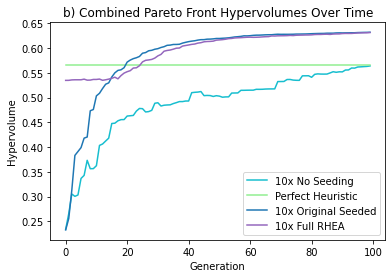

In [20]:
fig, ax = plt.subplots()
hv_params = [
    {"label": "10x No Seeding", "c": "C9"},
    {"label": "Perfect Heuristic", "c": "lightgreen"},
    {"label": "10x Original Seeded", "c": "C0"},
    {"label": "10x Full RHEA", "c": "C4"}
]
perfect_hypervolume = get_hypervolume(perfect_results, ref_point, ideal, OUTCOMES)
perfect_hypervolumes = [perfect_hypervolume] * 100
ax = plot_combined_hypervolumes(ax, [merged_noseed_hypervolumes, perfect_hypervolumes, merged_seed_hypervolumes, merged_rhea_hypervolumes], hv_params)
plt.show()

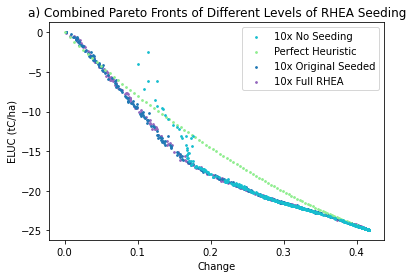

In [21]:
merged_params = [
    {"label": "10x Full RHEA", "s": 3, "color": "C4"},
    {"label": "10x Original Seeded", "s": 3, "color": "C0"},
    {"label": "Perfect Heuristic", "s": 3, "color": "lightgreen"},
    {"label": "10x No Seeding", "s": 3, "color": "C9"}
]
fig, ax = plt.subplots()
ax = compare_paretos(ax, [merged_rhea_results[-1], merged_seed_results[-1], perfect_results, merged_noseed_results[-1]], merged_params)
plt.show()

In [23]:
print(get_hypervolume(merged_noseed_results, ref_point, ideal, OUTCOMES))
print(get_hypervolume(merged_seed_results, ref_point, ideal, OUTCOMES))
print(get_hypervolume(merged_rhea_results, ref_point, ideal, OUTCOMES))

type: list indices must be integers or slices, not list

## Paper Figures

228it [00:00, 1204.03it/s]
228it [00:00, 1204.93it/s]


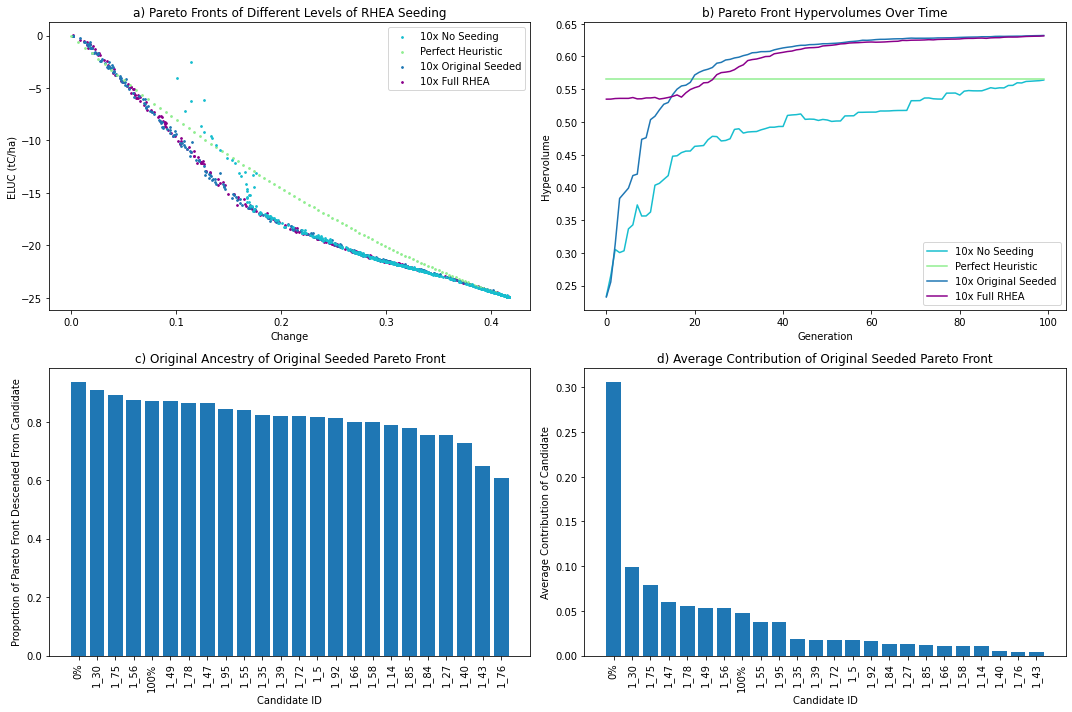

In [26]:
merged_params = [
    {"label": "10x Full RHEA", "s": 3, "color": "#8B008B"},
    {"label": "10x Original Seeded", "s": 3, "color": "C0"},
    {"label": "Perfect Heuristic", "s": 3, "color": "lightgreen"},
    {"label": "10x No Seeding", "s": 3, "color": "C9"}
]

hv_params = [
    {"label": "10x No Seeding", "c": "C9"},
    {"label": "Perfect Heuristic", "c": "lightgreen"},
    {"label": "10x Original Seeded", "c": "C0"},
    {"label": "10x Full RHEA", "c": "#8B008B"}
]

fig, axes = plt.subplots(2, 2, figsize=(15, 10), tight_layout=False)
axes = axes.flatten()
axes[0] = compare_paretos(axes[0], [merged_rhea_results[-1], merged_seed_results[-1], perfect_results, merged_noseed_results[-1]], merged_params, title="a) Pareto Fronts of Different Levels of RHEA Seeding")
axes[1] = plot_combined_hypervolumes(axes[1], [merged_noseed_hypervolumes, perfect_hypervolumes, merged_seed_hypervolumes, merged_rhea_hypervolumes], hv_params, title="b) Pareto Front Hypervolumes Over Time")
axes[2] = view_breadth(axes[2], SEEDED_DIR, 100, OUTCOMES)
axes[3] = view_dna(axes[3], SEEDED_DIR, 100, OUTCOMES)
plt.savefig(FIGURE_DIR / "rhea-fig.png", dpi=300, format="png")
plt.show()